<img src="imgs/qiskit.png" alt="QisKit" style="width: 50px;" align="right"/>

# Shor's Algorithm - Final Project
## Qiskit Global Summer School

<hr>

[Spencer Churchill](https://spencerchurchill.github.io)

In [1]:
# imports for RSA
from numpy import pi, mod, gcd, sqrt, log, ceil
from numpy.random import seed, randint

# imports for Shor
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

Introduction
- walking down wall street
- sees shady person drop paper scrap

In [2]:
def rsa(P, Q):
    N = P * Q # modulus <-- the hard number to crack!
    
    if N % 2 == 0:
        val = P if P % 2 == 0 else Q
        raise ValueError(f"{N} can not be divisible by 2.",
                         f"{P} and {Q} are incompatible with Shor's Algorithm.")
    
    L = (Q - 1) * (P - 1) # number of non-common factors (1, N)
    
    for E in range(2, L): # between [2, L)
        if gcd(L, E) * gcd(N, E) == 1: # coprime with both L and N
            break # E is public value

    D = 1
    while True:
        if D * E % L == 1 and D != E and D != N:
            break # D is private value
        D += 1

    return ((E, N), (D, N))

def dec_guess(string, key):
    D, N = key
    return "".join([chr((((ord(char) - ord('A'))**D) % N) +
                        ord('A')) for char in string])

- pick up paper scrap and read "buy `cdm` now. stock will boom! (?, 15)"

In [3]:
enc_str = "CBD"
N = 15

In [4]:
print(f"You know 3 things:\n\t1. a company is going to report high earnings",
      f"\n\t2. that company's encrypted stock listing is '{enc_str}'",
      f"and\n\t3. the key's coprime, N, is {N}.")

You know 3 things:
	1. a company is going to report high earnings 
	2. that company's encrypted stock listing is 'CBD' and
	3. the key's coprime, N, is 15.


- tries to guess 3 letter string

In [5]:
P = Q = 0
for i in range(3):
    print(dec_guess(enc_str, (i, 15)))

BBB
CBD
EBJ


- give up because it's too much work
- realize you watched Abe's lecture on Shor's algorithm

Shor's Algorithm

In [6]:
def initialize_qubits(given_circuit, n):
    given_circuit.h(range(n))
    given_circuit.x(-1)

def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{x} % 15"
    c_U = U.control()
    return c_U

def modular_exponentiation(given_circuit, n, a):
    for q in range(n):
        given_circuit.append(a_x_mod15(a, 2**q), 
                     [q] + [i+n for i in range(4)])

def apply_iqft(given_circuit, measurement_qubits):
    given_circuit.append(QFT(len(measurement_qubits), inverse=True,
                             do_swaps=False), measurement_qubits)

def shor_program(n, a):
    
    # set up quantum circuit
    shor = QuantumCircuit(n+4, n)
    
    # initialize the qubits
    initialize_qubits(shor, n)
    shor.barrier()

    # apply modular exponentiation
    modular_exponentiation(shor, n, a)
    shor.barrier()

    # apply inverse QFT
    apply_iqft(shor, range(n))
    shor.barrier()

    # measure the first n qubits
    shor.measure(range(n), range(n))
    
    return shor

In [7]:
seed(1) # This is to make sure we get reproduceable results

a = 0
while a == 0:
    b = randint(2, N)
    if gcd(b, N) == 1:
        a = b

print(f"N = {N}\na = {a}")

N = 15
a = 7


In [8]:
n = 3

mycircuit = shor_program(n, a)
mycircuit.draw(output='text')

┌───┐ ░                                         ░ ┌──────┐ ░ ┌─┐      
q_0: ┤ H ├─░───────■─────────────────────────────────░─┤0     ├─░─┤M├──────
     ├───┤ ░       │                                 ░ │      │ ░ └╥┘┌─┐   
q_1: ┤ H ├─░───────┼────────────■────────────────────░─┤1 qft ├─░──╫─┤M├───
     ├───┤ ░       │            │                    ░ │      │ ░  ║ └╥┘┌─┐
q_2: ┤ H ├─░───────┼────────────┼────────────■───────░─┤2     ├─░──╫──╫─┤M├
     └───┘ ░ ┌────┴┼─────┐┌────┴┼─────┐┌────┴┼─────┐ ░ └──────┘ ░  ║  ║ └╥┘
q_3: ──────░─┤0    │     ├┤0    │     ├┤0    │     ├─░──────────░──╫──╫──╫─
           ░ │           ││           ││           │ ░          ░  ║  ║  ║ 
q_4: ──────░─┤1          ├┤1          ├┤1          ├─░──────────░──╫──╫──╫─
           ░ │  7^1 % 15 ││  7^2 % 15 ││  7^4 % 15 │ ░          ░  ║  ║  ║ 
q_5: ──────░─┤2          ├┤2          ├┤2          ├─░──────────░──╫──╫──╫─
     ┌───┐ ░ │           ││           ││           │ ░          ░  ║  ║  ║ 
q_6: ┤ X ├─░─┤3          ├┤3          ├┤3          ├─░──────────░──╫──╫──╫─
     └───┘ ░ └───────────┘└───────────┘└───────────┘ ░          ░  ║  ║  ║ 
c_0: ══════════════════════════════════════════════════════════════╩══╬══╬═
                                                                      ║  ║ 
c_1: ═════════════════════════════════════════════════════════════════╩══╬═
                                                                         ║ 
c_2: ════════════════════════════════════════════════════════════════════╩═

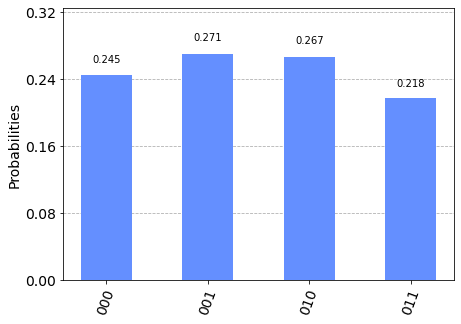

In [9]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(mycircuit, backend=simulator).result().get_counts(mycircuit)

plot_histogram(counts)

In [10]:
counts_dec = sorted([int(measured_value[::-1], 2) for measured_value in counts])

print("Measured:", end='\t')
for measured_value in counts_dec:
    print(measured_value, end='\t')

Measured:	0	2	4	6	

In [11]:
factors = set()

for measured_value in counts_dec:
    if measured_value % 2 == 0:
        x = int((a ** (measured_value/2)) % N)
        if (x + 1) % N != 0:
            guesses = [gcd(x + 1, N), gcd(x - 1, N)]
            for guess in guesses:
                if guess != 1 and guess != N and N % guess == 0:
                    factors.add(guess)

if len(factors) == 2:
    P = factors.pop()
    Q = factors.pop()
    print(f"P = {P}\nQ = {Q}")
else:
    print("Shor's Algorithm Failed. Choose a different 'a'.")

P = 3
Q = 5


- Use P and Q to retrieve the first half of the key

In [12]:
_, priv_key = rsa(P, Q)
print("Using RSA and Shor's Algorithm,",
      f"you determine the private key to be {priv_key}")

Using RSA and Shor's Algorithm, you determine the private key to be (23, 15)


- now you use that key to decrypt the stock listing

In [13]:
dec_str = dec_guess(enc_str, priv_key)
print(f"You find that the decrypted listing is {dec_str}!")

You find that the decrypted listing is IBM!


- being the smart quantum programmer that you are, you decide (not) to buy IBM stock. you enjoy the rest of your day knowing you did the right thing.

## Sources

- [Qiskit Textbook - Shor's Algorithm](https://qiskit.org/textbook/ch-algorithms/shor.html)
- [Qiskit Lecture](https://www.crowdcast.io/e/qgss-day4)
- [RSA Tutorial](https://hackernoon.com/how-does-rsa-work-f44918df914b)